# Lab 8: Graphical Models

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

You have to send the filled notebook named **"L8_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before December 12, 2019 at 23:59 and put **"AML-L8"** as subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import networkx as nx
import scipy
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [64]:
class MyGraphicalLasso():
    
    def __init__(self, alpha, mu, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.alpha = alpha
        self.mu = mu
        self.max_iter = max_iter
        self.graph_structure_ = None
        #self.tol = tol

    def function(self, X, nu):
        eig_values, eig_vectors = np.linalg.eig(X)
        new_eig_values = (eig_values + np.sqrt(eig_values**2 + 4/nu))/2
        return eig_vectors.T @ np.diag(new_eig_values) @ eig_vectors
        
    def soft_thresholding(self, G, Z, c):
        return np.multiply(np.sign(G+Z), np.maximum(0, np.absolute(G+Z) - c))
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         

        n, p = X.shape
        Y = np.eye(p)
        Z = np.eye(p)
        mu_hat = (1/n)*np.mean(X, axis = 0)
        S = np.zeros((p,p))
        for i in range(n):
            X_center = (X[i] - mu_hat).reshape(-1,1)
            S += X_center@X_center.T
        S /= n  
        iteration = 0
        # until convergence:
        while iteration < self.max_iter:
            iteration += 1
            matrix = Y-Z-S/self.mu
            Gamma = self.function(matrix, self.mu)
            Y = self.soft_thresholding(Gamma, Z, self.alpha/self.mu)
            Z = Z + self.mu*(Gamma - Y)
        self.precision_ = self.graph_structure_ = Gamma
        return self
    
    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            "mu": self.mu,
            "max_iter": self.max_iter,
#             "tol": self.tol
        }
    
    def set_params(self, **params):
        if "alpha" in params:
            self.alpha_ = params["alpha"]
        if "mu" in params:
            self.mu_ = params["mu"]
        return self

In [3]:
X = np.array([[1,2],[4,5]])
u, s, vh = np.linalg.svd(X)

print(u@np.diag(s)@vh)

[[1. 2.]
 [4. 5.]]


Estimating the precision matrix from 60 samples... 



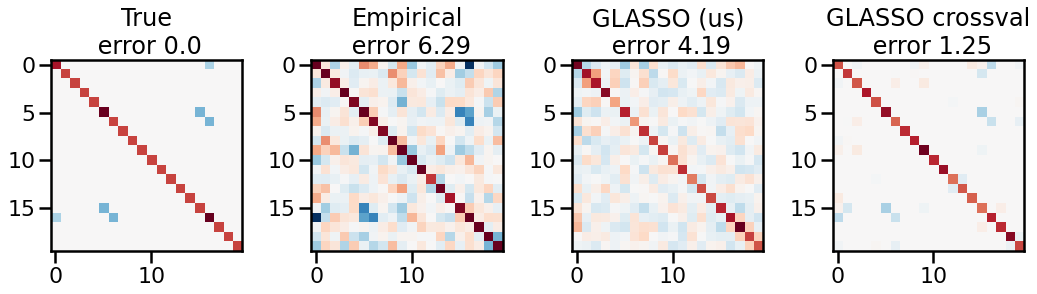

In [63]:
# Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

print(f'Estimating the precision matrix from {n_samples} samples... \n')


# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV
model = GraphicalLassoCV(cv=5)
model.fit(data)
prec_glassocv = model.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
model = MyGraphicalLasso(alpha = 0.12, mu = 0.5)
#model = MyGraphicalLasso(alpha = 0.01, nu = 0.5)
model.fit(data)
prec_glasso = model.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)
vmax = prec_glasso.max()


# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()

Comment on the different methods' ability to recover the precision matrix structure and what that means in terms of the graph between features. 

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [29]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule, alpha):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.alpha = alpha
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO:
        # Estimate the precision structure
        n = X.shape[1]
        beta = np.zeros((n,n))
        for j in range(n):
            y = X[:,j]
            x = np.delete(X, j, axis = 1)
            regression = sklearn.linear_model.Lasso(alpha=self.alpha)
            regression.fit(X=x, y=y)
            beta[j, :j], beta[j, j+1:] = regression.coef_[:j], regression.coef_[j:]
            if self.rule == "OR":
                beta = np.absolute(beta) > 0
                adj = beta | beta.T
                
            elif self.rule == "AND":
                beta = np.absolute(beta) > 0
                adj = beta & beta.T
        #print(adj)
        self.graph_structure_ = adj
        return self


Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` to plot the resulting graph.

In [16]:
mu = [0, 1, -1]
cov = np.array([
    [1,2,0],
    [2,1,0],
    [0,0,1]
])
cov = cov.T@cov
X = np.array([np.random.multivariate_normal(mu, cov) for i in range(50)])
precision_matrix = np.linalg.inv(cov)   #matrix K connections of the graph
print(precision_matrix) 

[[ 0.55555556 -0.44444444  0.        ]
 [-0.44444444  0.55555556  0.        ]
 [ 0.          0.          1.        ]]


## Testing the Models

In [1]:
model_glasso = MyGraphicalLasso(alpha=0.4, mu=1)
model_glasso.fit(X)

model_nor = my_nodewise_regression(rule="OR", alpha=1)
model_nor.fit(X)

model_nand = my_nodewise_regression(rule="AND", alpha=1)
model_nand.fit(X)

NameError: name 'MyGraphicalLasso' is not defined

In [18]:
def drawing_graph(model, node_labels=True, edge_labels=True):
    K = model.graph_structure_
    G = nx.Graph()
    G.add_nodes_from(range(K.shape[0]))
    nonzeros = list(zip(*np.nonzero(K), [{"weight": K[nz]} for nz in zip(*np.nonzero(K))]))
    G.add_edges_from(nonzeros)

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, label=None, alpha=0.5)
    if node_labels:
        nx.draw_networkx_labels(G, pos)
    if edge_labels:
        edge_labels = {(u, v): "{:.3f}".format(d) for (u,v,d) in G.edges(data="weight") if u != v}
        nx.draw_networkx_edge_labels(G, pos, edge_labels)
        
def true_graph(K, node_labels=True, edge_labels=True):
    G = nx.Graph()
    G.add_nodes_from(range(K.shape[0]))

    nonzeros = list(zip(*np.nonzero(K), [{"weight": K[nz]} for nz in zip(*np.nonzero(K))]))
    G.add_edges_from(nonzeros)

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, label=None, alpha=0.5)
    if node_labels:
        nx.draw_networkx_labels(G, pos)
    if edge_labels:
        edge_labels = {(u, v): "{:.3f}".format(d) for (u,v,d) in G.edges(data="weight") if u != v}
        nx.draw_networkx_edge_labels(G, pos, edge_labels)

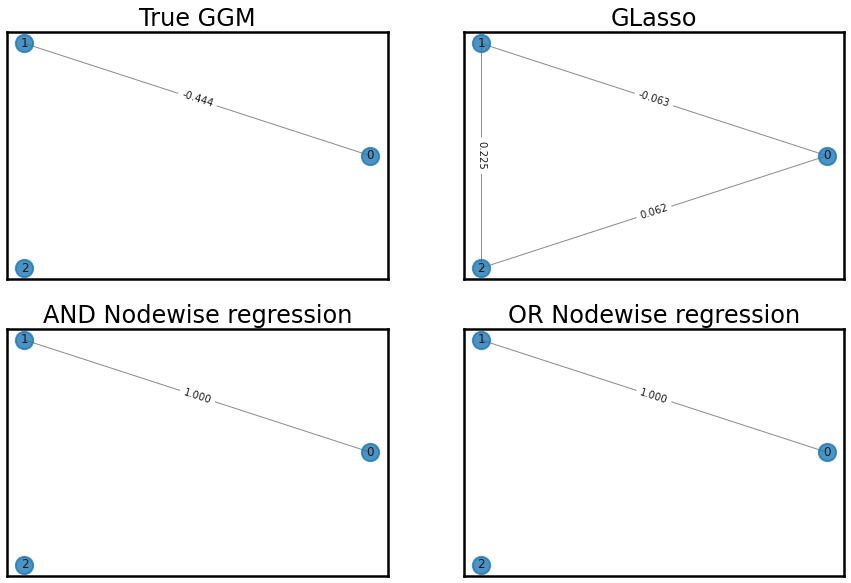

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(221)
true_graph(precision_matrix)
plt.title("True GGM")
plt.subplot(222)
drawing_graph(model_glasso)
plt.title("GLasso")
plt.subplot(223)
drawing_graph(model_nand)
plt.title("AND Nodewise regression")
plt.subplot(224)
drawing_graph(model_nor)
plt.title("OR Nodewise regression")
plt.show()

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [21]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

### Test Data

In [74]:
n_blocks = 10
block_size = 30
n = 80

block = [[0.9**(abs(i - j)) for i in range(block_size)] for j in range(block_size)]
cov = scipy.linalg.block_diag(*[block]*n_blocks)
#print(cov)
precision_1 = np.linalg.inv(cov)

X = np.array([np.random.multivariate_normal(np.ones((n_blocks * block_size,)), cov) for _ in range(n)])
print(X.shape)

(300, 300)
(80, 300)


## Glasso

### Choosing Parameter alpha

In [116]:
def Frobenius_norm(estimator, y=None):
    precision_bis = estimator.precision_
    return np.linalg.norm(precision_bis - precision_1)

def likelihood(estimator, X, y=None):
    n_samples, n_features = X.shape
    precision = estimator.precision_
    det = np.linalg.det(precision)
    if det < 1e-3:
        det = 1e-3
    elif det > 1e3:
        det = 1e3
    
    esperance = X.mean(axis=0)
    S = np.zeros((n_features, n_features))
    for i in range(n_samples):
        dev = (X[i] - esperance).reshape(-1,1)
        S += dev@dev.T
    S /= n_samples
    
    return np.log(det) - np.trace(S@precision)

# Je crois pas que ca marche

In [115]:
alpha_values = [1e-4, 1e-3,1e-3, 1e-1, 1]
clf = GridSearchCV(estimator= MyGraphicalLasso(alpha = 1, mu = 1),
            param_grid={'alpha': alpha_values},
            scoring=likelihood, cv=3, n_jobs=3)

# from sklearn.covariance import GraphicalLassoCV
# clf = GraphicalLassoCV()
clf.fit(X)
#print(clf.alpha_)
#print(min(clf.grid_scores_))

#print(clf.get_params)
print(clf.best_params_)
print(clf.best_score_)

C:\Users\inesp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:802: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=np.float64).reshape(n_candidates,


{'alpha': 0.0001}
-88.39643350408676


## Nodewise Regression

In [30]:
model_nodewise_or = my_nodewise_regression(rule="OR", alpha=1)
model_nodewise_or.fit(X)

model_nodewise_and = my_nodewise_regression(rule="AND", alpha=1)
model_nodewise_and.fit(X)

In [138]:
# def edge_f1(model_precision, real_precision):   
#     n = model_precision.shape[0]
#     triu_indices = np.triu_indices(n)
#     #print(model_precision)
#     model = np.absolute(model_precision[triu_indices]) > 1e-5
#     #print(model)
#     real = np.absolute(real_precision[triu_indices]) > 1e-5
#     acc = accuracy_score(real, model)
#     #acc = accuracy_score(real_precision, model_precision)
#     f1 = f1_score(real, model)
#     return acc, f1

def edge_f1(model_precision, real_precision):   
    n = model_precision.shape[0]
    model = np.absolute(model_precision) > 1e-7
    real = np.absolute(real_precision) > 1e-7
    acc = accuracy_score(real.flatten(), model.flatten())
    f1 = f1_score(real.flatten(), model.flatten())
    return acc, f1

In [139]:
acc, f1 = edge_f1(model_nodewise_and.graph_structure_, precision)
print('The accuracy for AND model_nodewise is: '+ str(acc))
print('The f1 score for AND model_nodewise is: '+ str(f1))

The accuracy for AND model_nodewise is: 0.9911555555555556
The f1 score for AND model_nodewise is: 0.17427385892116184


In [140]:
acc, f1 = edge_f1(model_nodewise_or.graph_structure_, precision)
print('The accuracy for OR model_nodewise is: '+ str(acc))
print('The f1 score for OR model_nodewise is: '+ str(f1))

The accuracy for OR model_nodewise is: 0.9920222222222222
The f1 score for OR model_nodewise is: 0.3187855787476281


## Comments

*Comment and compare the methods and the effect of the sample size.*